<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Text_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

# Imports

In [0]:
import torch
import random
import re
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from torchtext.vocab import GloVe
from transformers import BertModel, BertTokenizer

# Arguments

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_model": "bert-base-uncased",
    "seed": 1234,
    "bert_embedding_dim": 768,
    "use_glove": False,
    "glove_embedding_dim": 300,
    "max_vocab_size": 20000,
    "batch_size": 10,
    "num_filters": 100,
    "filter_sizes": [1, 1, 1],
    "output_dim": 11,
    "dropout": 0.5,
    "epochs": 10
}

# Text pre-processor

In [0]:
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', '')) 
  return text.split()

# Setup Bert Tokenizer

In [0]:
tokenizer = BertTokenizer.from_pretrained(args['bert_model'])

In [271]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_model']]

print(max_input_length)

512


# Tokenize text

In [0]:

def tokenize(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load & Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

if args['use_glove']:
  TEXT = data.Field(batch_first=True,
                    tokenize=preprocessor,
                    use_vocab=True,
                    sequential=True)

else:
  TEXT = data.Field(batch_first = True,
                    use_vocab = False,
                    tokenize = tokenize,
                    preprocessing = tokenizer.convert_tokens_to_ids,
                    init_token = tokenizer.cls_token_id,
                    eos_token = tokenizer.sep_token_id,
                    pad_token = tokenizer.pad_token_id,
                    unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

# Load GloVe vectors

In [0]:
if args['use_glove']:
  TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300), 
                   max_size=args['max_vocab_size'])
  print(f"\nUnique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

# Setup Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers


In [0]:
bert = BertModel.from_pretrained(args['bert_model'])

We use the pre-trained bert transformer model to produce embeddings which are then fed into the TextCNN architecture proposed by Yoon Kim at: https://arxiv.org/abs/1408.5882

In [0]:
class TextCNN(nn.Module):
  def __init__(self, n_filters, filter_sizes, output_dim, dropout):
    super().__init__()

    if args['use_glove']:
      embedding_dim = args['glove_embedding_dim']
      self.embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
    else: 
      self.bert = bert 
      embedding_dim = 768

    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1,
                                          out_channels = n_filters,
                                          kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    if args['use_glove']:
      embedded = self.embedding(text)
    else:
      with torch.no_grad():
        embedded = self.bert(text)[0]
    
    embedded = embedded.unsqueeze(1)
    
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    
    cat = self.dropout(torch.cat(pooled, dim = 1))
    
    return self.fc(cat)

In [279]:
model = TextCNN(n_filters=args['num_filters'], 
                # filter_sizes=[1,1,1] if args['use_glove'] else args['filter_sizes'],
                filter_sizes=args['filter_sizes'],
                output_dim=args['output_dim'], 
                dropout=args['dropout'])

model

TextCNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

Next we freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
if args['use_glove'] is False:
  for name, param in model.named_parameters():                
      if name.startswith('bert'):
          param.requires_grad = False

In [281]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

convs.0.weight
convs.0.bias
convs.1.weight
convs.1.bias
convs.2.weight
convs.2.bias
fc.weight
fc.bias


# Train the Model

In [0]:
import torch.optim as optim
import pandas as pd

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard Index and the macro and micro F1's as there are more suitable for multi-label text classification.

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  #acc = roc_auc_score(y, preds)
  jaccard = jaccard_score(y, preds.round(), average='samples')

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'jaccard': jaccard
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()
    
    if args['use_glove']:
      predictions = model(batch.Tweet)
    else:
      predictions = model(batch.Tweet).squeeze(1)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      if args['use_glove']:
        predictions = model(batch.Tweet)
      else:
        predictions = model(batch.Tweet).squeeze(1)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss.


In [289]:
best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if args['use_glove']:
          torch.save(model.state_dict(), 'glove-cnn-model.pt')
        else:
          torch.save(model.state_dict(), 'bert-cnn-model.pt')

    train_jaccard = train_metrics['jaccard']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_jaccard = valid_metrics['jaccard']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Jaccard: {train_jaccard*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Jaccard: {valid_jaccard*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 0.394 | Train Jaccard: 34.05% | Train F1 Micro: 48.41% | Train F1 Macro: 31.07%
	 Val. Loss: 0.324 | Val. Jaccard: 47.59%  | Val. F1 Micro: 62.08%  | Val. F1 Macro: 42.43%
Epoch: 02 | Epoch Time: 0m 39s
	Train Loss: 0.339 | Train Jaccard: 46.29% | Train F1 Micro: 60.55% | Train F1 Macro: 42.44%
	 Val. Loss: 0.319 | Val. Jaccard: 51.37%  | Val. F1 Micro: 64.94%  | Val. F1 Macro: 42.92%
Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.327 | Train Jaccard: 48.57% | Train F1 Micro: 62.90% | Train F1 Macro: 45.25%
	 Val. Loss: 0.316 | Val. Jaccard: 53.19%  | Val. F1 Micro: 66.54%  | Val. F1 Macro: 45.91%
Epoch: 04 | Epoch Time: 0m 39s
	Train Loss: 0.319 | Train Jaccard: 49.37% | Train F1 Micro: 63.59% | Train F1 Macro: 47.06%
	 Val. Loss: 0.315 | Val. Jaccard: 52.20%  | Val. F1 Micro: 65.48%  | Val. F1 Macro: 45.16%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.312 | Train Jaccard: 50.56% | Train F1 Micro: 64.52% | Train F1 Macro: 48.73%
	 Val. Loss:

# Visualize the training and validation loss

In [0]:
import matplotlib.pyplot as plt

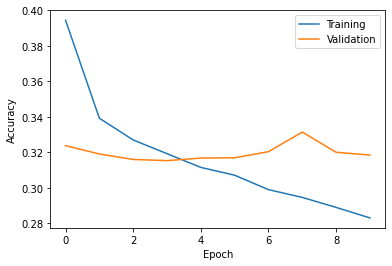

In [291]:
plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

# Assess model performance on testing data

In [292]:
model.load_state_dict(torch.load('bert-cnn-model.pt'))

test_loss, test_metrics = evaluate(model, test_iterator, criterion)

test_jaccard = test_metrics['jaccard']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Jaccard: {test_jaccard*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.313 | Test Jaccard: 52.70% | Test F1 Micro: 65.92% | Test F1 Macro: 46.25%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()

  if args['use_glove']:
    tokenized = preprocessor(tweet)
    indexed = [TEXT.vocab.stoi[token] for token in tokenized]
  else:
    tokens = tokenizer.tokenize(tweet)
    tokens = tokens[:max_input_length-2]
    indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.sep_token_id]
    
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())
  return preds

In [0]:
preds = predict_emotion(model, tokenizer, "Good music, I love that shit.")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.5907741785049438
ANTICIPATION: 0.011862020939588547
DISGUST: 0.22723861038684845
FEAR: 0.0067725153639912605
JOY: 0.9571667909622192
LOVE: 0.8796480298042297
OPTIMISM: 0.5829552412033081
PESSIMISM: 0.03534362092614174
SADNESS: 0.030489809811115265
SURPRISE: 0.011094095185399055
TRUST: 0.05025497078895569
